## Прогнозирование стоимости автомобиля по характеристикам

<b>Задача проекта:</b> создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. <br>
Данные для тренеровочного датасета необходимо собрать самостоятеьно. <br>
Результатом выполнения работы является получение наименьшего <b>MAPE</b> на тестовом датасете в соревновании на <b><a href=https://www.kaggle.com/c/sf-dst-car-price-prediction/overview/description>Kaggle</a></b>.

In [2998]:
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup
from collections import defaultdict
import time

import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy
from datetime import datetime
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer
from sklearn.feature_selection import f_classif, mutual_info_classif

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2999]:
RANDOM_SEED = 42
warnings.filterwarnings('ignore')
DIR   = '../input/train-cars/'
sample_submission = pd.read_csv(DIR +'sample_submission.csv')

In [3000]:
# функция для целевой метрики
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_pred-y_true)/y_true))

## Знакомство с тестовым датасетом

Загрузим тестовый датасет и посмотрим на признаки.

In [3001]:
test = pd.read_csv(DIR+'test.csv')

In [3072]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   color                34686 non-null  object 
 3   complectation_dict   6418 non-null   object 
 4   engineDisplacement   34686 non-null  object 
 5   enginePower          34686 non-null  object 
 6   equipment_dict       24690 non-null  object 
 7   fuelType             34686 non-null  object 
 8   mileage              34686 non-null  int64  
 9   modelDate            34686 non-null  int64  
 10  model_name           34686 non-null  object 
 11  numberOfDoors        34686 non-null  int64  
 12  productionDate       34686 non-null  int64  
 13  sell_id              34686 non-null  int64  
 14  vehicleTransmission  34686 non-null  object 
 15  vendor               34686 non-null 

In [3002]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


<b>Признаки для парсинга:</b> <br><br>

<b>'bodyType'</b> - тип кузова, <br>
<b>'brand'</b> - марка, <br>
<b>'color'</b> - цвет,<br>
<b>'complectation_dict'</b> - наличие комплектации,<br>
<b>'engineDisplacement'</b> - объем двигателя,<br>
<b>'enginePower'</b> - мощность двигателя,<br>
<b>'equipment_dict'</b> - наличие оборудования,<br>
<b>'fuelType'</b> - топливо, <br>
<b>'mileage'</b> - пробег,<br>
<b>'modelDate'</b> - год модели,<br>
<b>'model_name'</b> - название модели,<br>
<b>'numberOfDoors'</b> - количество дверей,<br>
<b>'productionDate'</b> - год производства, <br>
<b>'sell_id'</b> - идентификатор продажи,<br>
<b>'vehicleTransmission'</b> - трансмиссия, <br>
<b>'vendor'</b> - производитель, <br>
<b>'Владельцы'</b>, <br>
<b>'ПТС'</b>,<br>
<b>'Привод'</b>, <br>
<b>'Руль'</b>, <br>
<b>'Price'</b> - цена

In [3003]:
# марка автомобиля
test.brand.value_counts()

BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741
VOLVO         1463
HONDA         1150
INFINITI       871
LEXUS          834
Name: brand, dtype: int64

Добывать данные будем соотвествующиx марок:

In [3004]:
brands = []

for i in test.brand.unique():
    brands.append(i.lower())

### Удаление признаков

Признак <b>'description'</b> содержит авторское описание и, в основном, дублирует уже имеющуюся информацию из остальных признаков.<br>
Информация из признаков <b>'model_info'</b>, <b>name</b>, <b>'super_gen'</b>, <b>'vehicleConfiguration'</b> дублируют информацию из других признаков.<br>
Признак <b>'Владение'</b> содержит много пропусков. Избавимся и от него.
Признаки <b>'priceCurrency'</b>, <b>'Состояние'</b>, <b>'Таможня'</b> состоят из одного значения.<br>
Также избавимся от признаков, которые скорее всего не помогут в предсказании: <b>'car_url'</b>, <b>'image'</b>, <b>'parsing_unixtime'</b>. <br>


In [3005]:
test.drop(['description', 'model_info', 'name','super_gen', 'Владение', 'vehicleConfiguration', 'priceCurrency', 'Состояние', 'Таможня', 'car_url', 'image', 'parsing_unixtime'], axis=1, inplace=True)

## <center>Парсинг данных</center>

Мы определились с признаками, которые нужно добыть. Парсить данные будем с сайта <a href="http://www.auto.ru">auto.ru</a>. <br>
Исходя из задания, парсить будем машины с пробегом из Москвы.

Сохраняем в отдельный файл ссылки на все интересующие автомобили:

In [3006]:
cars_urls = []

for brand in brands:
    brand_url = 'https://auto.ru/moskva/cars/' + brand +'/used/?page='
    
    for number in range(1, 100):
        
        response = requests.get(brand_url+str(number))

        page = BeautifulSoup(response.text, 'html.parser')
        link_list = page.find_all('a', class_='Link ListingItemTitle-module__link')


        if len(link_list) !=0:
            for link in link_list:
                cars_urls.append(link['href'])
                #time.sleep(1.5)
        else:
            break
            
            
with open('cars_urls.json', 'w') as a:
    json.dump(cars_urls, a)

Код для парсинга данных:

In [3007]:
train_brands =  defaultdict(list) #создаем словарь для записи парсинга

for car_url in cars_urls:
    
    time.sleep(1.5)
    
    response = requests.get(car_url)
    response.encoding = 'utf8'
    page = BeautifulSoup(response.text, 'html.parser')
          
    
    try:
        data0 = json.loads(page.find_all('script')[0].string)

        bodyType = data0['bodyType']
        brand = data0['brand']
        color = data0['color']
        engineDisplacement = data0['vehicleEngine']['engineDisplacement']
        enginePower = data0['vehicleEngine']['enginePower']
        fuelType = data0['fuelType']
        modelDate = data0['modelDate']
        numberOfDoors = data0['numberOfDoors']
        productionDate = data0['productionDate']
        vehicleTransmission = data0['vehicleTransmission']
        price = data0['offers']['price']

        data10 = json.loads(page.find_all('script')[10].string)

        equipment_dict = data10['card']['vehicle_info']['equipment']
        mileage = data10['card']['state']['mileage']
        model_name = data10['router']['current']['params']['model']
        sell_id = data10['router']['current']['params']['sale_id']
        vendor = data10['card']['vehicle_info']['vendor']
        owners = data10['card']['documents']['owners_number']
        pts = data10['card']['documents']['pts']
        car_drive = data10['card']['vehicle_info']['tech_param']['gear_type']
        steering_wheel = data10['card']['vehicle_info']['steering_wheel']
        complectation_dict = data10['card']['vehicle_info']['complectation']['name']


        #если ошибки (try) не случилось, то добавлем все в словарь:

        train_brands['bodyType'].append(bodyType)
        train_brands['brand'].append(brand)
        train_brands['color'].append(color)
        train_brands['engineDisplacement'].append(engineDisplacement)
        train_brands['enginePower'].append(enginePower)
        train_brands['fuelType'].append(fuelType)
        train_brands['modelDate'].append(modelDate)
        train_brands['numberOfDoors'].append(numberOfDoors)
        train_brands['productionDate'].append(productionDate)
        train_brands['vehicleTransmission'].append(vehicleTransmission)
        train_brands['price'].append(price)
        train_brands['mileage'].append(mileage)
        train_brands['model_name'].append(model_name)
        train_brands['sell_id'].append(sell_id)
        train_brands['vendor'].append(vendor)
        train_brands['Владельцы'].append(owners)
        train_brands['ПТС'].append(pts)
        train_brands['Привод'].append(car_drive)
        train_brands['Руль'].append(steering_wheel)

        if len(equipment_dict) > 0:
            train_brands['equipment_dict'].append(1)
        else:
            train_brands['equipment_dict'].append(0)
        if len(complectation_dict) > 1:
            train_brands['complectation_dict'].append(1)
        else:
            train_brands['complectation_dict'].append(0)
     
    except:
        continue #если по ссылке где-то выдается ошибка, то перейти к следующему авто
       
    
with open('train_brands.json', 'w') as b:
    json.dump(train_brands, b)

train_brands = pd.DataFrame(train_brands) # преобразуем наш датасет из join в DataFrame

train_brands.to_csv('train_brands.csv', index=False) # записываем датасет в файл csv для удобства работы 

Наш тренировочный тест готов!

In [3008]:
train = pd.read_csv(DIR+'train_brands.csv')

In [3073]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28825 entries, 0 to 28824
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bodyType             28825 non-null  object
 1   brand                28825 non-null  object
 2   color                28825 non-null  object
 3   engineDisplacement   28825 non-null  object
 4   enginePower          28825 non-null  object
 5   fuelType             28825 non-null  object
 6   modelDate            28825 non-null  int64 
 7   numberOfDoors        28825 non-null  int64 
 8   productionDate       28825 non-null  int64 
 9   vehicleTransmission  28825 non-null  object
 10  price                28825 non-null  int64 
 11  complectation_dict   28825 non-null  int64 
 12  equipment_dict       28825 non-null  int64 
 13  mileage              28825 non-null  int64 
 14  model_name           28825 non-null  object
 15  sell_id              28825 non-null  int64 
 16  vend

In [3009]:
train.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,...,complectation_dict,equipment_dict,mileage,model_name,sell_id,vendor,Владельцы,ПТС,Привод,Руль
13111,пикап двойная кабина,NISSAN,чёрный,2.5 LTR,133 N12,дизель,2008,4,2008,механическая,...,0,1,206927,np300,1103327673,JAPANESE,1,ORIGINAL,ALL_WHEEL_DRIVE,LEFT
20343,седан,TOYOTA,серебристый,1.5 LTR,105 N12,бензин,1991,4,1997,автоматическая,...,0,0,309000,corolla,1103372372,JAPANESE,4,DUPLICATE,FORWARD_CONTROL,RIGHT
7241,внедорожник 5 дв.,VOLVO,белый,2.0 LTR,225 N12,дизель,2014,5,2015,автоматическая,...,1,1,260000,xc90,1103516121,EUROPEAN,4,DUPLICATE,ALL_WHEEL_DRIVE,LEFT
14075,седан,NISSAN,серебристый,2.0 LTR,140 N12,бензин,1999,4,2002,автоматическая,...,0,1,335000,maxima,1103240188,JAPANESE,3,ORIGINAL,FORWARD_CONTROL,LEFT
25851,седан,VOLKSWAGEN,синий,1.8 LTR,170 N12,бензин,2000,4,2003,механическая,...,0,1,303000,passat,1103150874,EUROPEAN,4,DUPLICATE,FORWARD_CONTROL,LEFT


## Разведывательный анализ данных

In [3010]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

test['price'] = np.NaN # целевая переменная, котрую мы должны предсказать

data = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [3011]:
data.sample(5)

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,modelDate,numberOfDoors,productionDate,vehicleTransmission,...,equipment_dict,mileage,model_name,sell_id,vendor,Владельцы,ПТС,Привод,Руль,Train
26920,седан,MITSUBISHI,серебристый,1.6 LTR,117 N12,бензин,2011,4,2012,автоматическая,...,1,124508,lancer,1103518492,JAPANESE,1,ORIGINAL,FORWARD_CONTROL,LEFT,1
14144,внедорожник 5 дв.,NISSAN,чёрный,2.0 LTR,141 N12,бензин,2007,5,2007,вариатор,...,1,195000,x_trail,1103031846,JAPANESE,3,DUPLICATE,ALL_WHEEL_DRIVE,LEFT,1
44687,седан,MERCEDES,белый,2.1 LTR,204 N12,дизель,2013,4,2013,автоматическая,...,"{""cruise-control"":true,""engine-proof"":true,""as...",121413,E_KLASSE,1101262558,EUROPEAN,3 или более,Оригинал,полный,Левый,0
23162,внедорожник 5 дв.,LEXUS,синий,3.5 LTR,276 N12,бензин,2006,5,2006,автоматическая,...,1,240000,rx,1102960517,JAPANESE,3,ORIGINAL,ALL_WHEEL_DRIVE,LEFT,1
50096,седан,TOYOTA,чёрный,2.4 LTR,167 N12,бензин,2009,4,2010,автоматическая,...,NaN,180000,CAMRY,1101307683,JAPANESE,2 владельца,Дубликат,передний,Левый,0


In [3012]:
data.isnull().sum() #наличие пропусков в объединенном датасете

bodyType                   0
brand                      0
color                      0
engineDisplacement         0
enginePower                0
fuelType                   0
modelDate                  0
numberOfDoors              0
productionDate             0
vehicleTransmission        0
price                  34686
complectation_dict     28268
equipment_dict          9996
mileage                    0
model_name                 0
sell_id                    0
vendor                     0
Владельцы                  0
ПТС                        1
Привод                     0
Руль                       0
Train                      0
dtype: int64

В признаке <b>'price'</b> пропуски только в тестовом датасете. Так и должно быть. <br>
Признаки <b>'complectation_dict'</b>, <b>'equipment_dict'</b>, <b>'ПТС'</b> нужно будет заполнить.

### Заполнение пропусков и приведение к общему виду

<b>'complectation_dict'</b>

Заполним пустые значения и приведем признак к общему виду с помощью функции.

In [3013]:
def complectation_func(x):
    if pd.notnull(x):
        if str(x)[:6] == '{"id":':
            return 1
        else:
            return x
    else:
        return 0

In [3014]:
data['complectation_dict'] = data['complectation_dict'].apply(complectation_func)

<b>'equipment_dict'</b>

Заполним пустые значения и приведем признак к общему виду с помощью функции.

In [3015]:
def equipment_func(x):
    if pd.notnull(x):
        if str(x)[:2] == '{"':
            return 1
        else:
            return int(x)
    else:
        return 0

In [3016]:
data['equipment_dict'] = data['equipment_dict'].apply(equipment_func)

#### 'enginePower'

In [3017]:
# переводим в числовое значение мощность двигателя
data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:3]))

#### 'engineDisplacement'

Объем двигателя измеряется в литрах. Приведем данные к числовым значениям. Электромобили не имеют объема двигателя, поэтому заменим этот показатель средним значением.

In [3018]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: float(x[:3]) if x != ' LTR' else np.nan)

In [3019]:
data['engineDisplacement'] = data['engineDisplacement'].fillna(data['engineDisplacement'].mean())

<b>'ПТС'</b>

In [3020]:
data['ПТС'] = data['ПТС'].fillna('Дубликат') # заполним один объект с пустым значением

In [3021]:
data['ПТС'] = data['ПТС'].apply(lambda x : 'Оригинал' if x == 'ORIGINAL' or  x == 'Оригинал' else 'Дубликат') # приведем к единому виду

In [3022]:
data['ПТС'].value_counts()

Оригинал    55101
Дубликат     8410
Name: ПТС, dtype: int64

<b>'Привод'</b>

In [3023]:
def control(x):
    if x == 'ALL_WHEEL_DRIVE':
        return 'полный'
    elif x == 'FORWARD_CONTROL':
        return 'передний'
    elif x == 'REAR_DRIVE':
        return 'задний'
    else:
        return x

In [3024]:
data['Привод'] = data['Привод'].apply(control) # приведем данные к тестовому виду

In [3025]:
data['Привод'].value_counts()

полный      28285
передний    28138
задний       7088
Name: Привод, dtype: int64

<b>'Руль'</b>

In [3026]:
data['Руль'] = data['Руль'].apply(lambda x : 'Левый' if x == 'Левый' or  x == 'LEFT' else 'Правый') # приведем к бинарному стилю

In [3027]:
data['Руль'].value_counts()

Левый     60896
Правый     2615
Name: Руль, dtype: int64

#### 'Владельцы'

In [3028]:
def owners(x):
    if x == '1\xa0владелец':
        return 1
    elif x == '2\xa0владельца':
        return 2
    elif x == '3 или более' or x == 4:
        return 3
    else:
        return x

In [3029]:
data['Владельцы'] = data['Владельцы'].apply(owners)

In [3030]:
data['Владельцы'].value_counts()

3    28163
1    18341
2    17007
Name: Владельцы, dtype: int64

### Группировка признаков

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа:

In [3031]:
# разобъем данные по категориям
num_cols = ['enginePower', 'mileage', 'modelDate', 'productionDate', 'engineDisplacement', 'Владельцы']
bin_cols = ['vendor', 'ПТС', 'Руль', 'complectation_dict', 'equipment_dict']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission', 'Привод', 'model_name']

### Числовые признаки

#### Распределение числовых данных:

<AxesSubplot:title={'center':"Распределение по признаку 'Владельцы'"}, ylabel='Frequency'>

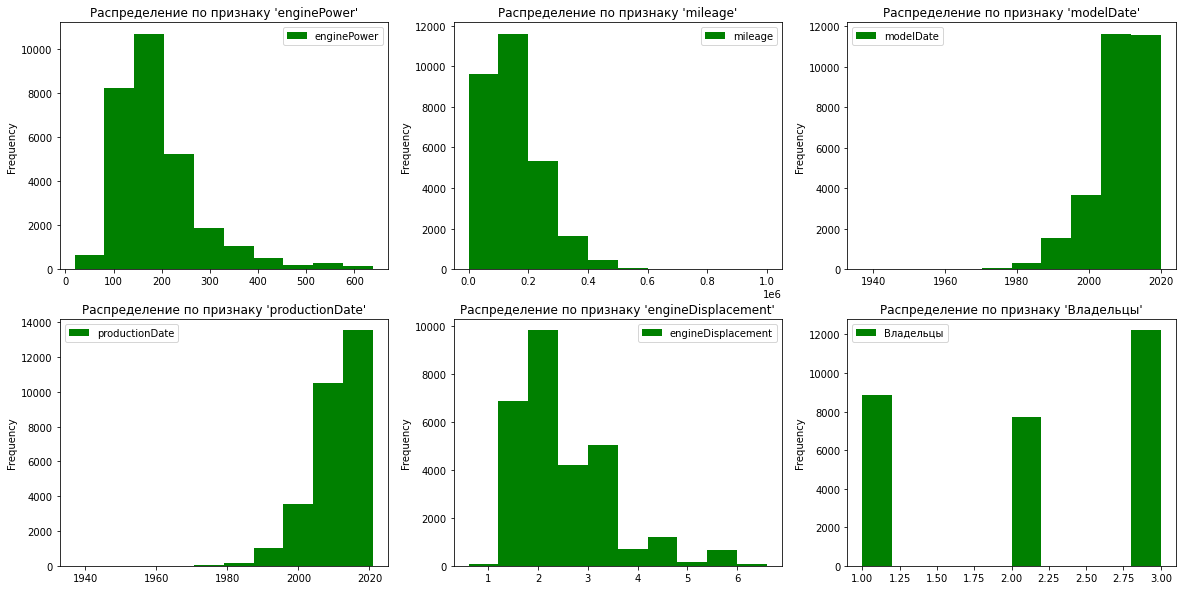

In [3032]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)
ax_6 = fig.add_subplot(2, 3, 6) 


data[data['Train'] == 1].plot(y='enginePower', kind='hist', color='green', title="Распределение по признаку 'enginePower'", ax=ax_1)
data[data['Train'] == 1].plot(y='mileage', kind='hist', color='green', title="Распределение по признаку 'mileage'", ax=ax_2)
data[data['Train'] == 1].plot(y='modelDate', kind='hist', color='green', title="Распределение по признаку 'modelDate'", ax=ax_3)
data[data['Train'] == 1].plot(y='productionDate', kind='hist', color='green', title="Распределение по признаку 'productionDate'", ax=ax_4)
data[data['Train'] == 1].plot(y='engineDisplacement', kind='hist', color='green', title="Распределение по признаку 'engineDisplacement'", ax=ax_5)
data[data['Train'] == 1].plot(y='Владельцы', kind='hist', color='green', title="Распределение по признаку 'Владельцы'", ax=ax_6)

#### Оценка корреляций

Оценим корреляцию Пирсона для непрерывных переменных:

<AxesSubplot:>

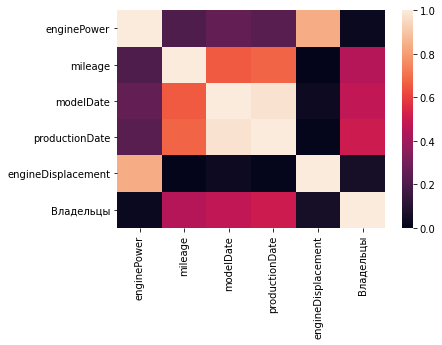

In [3033]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Как мы можем заметить существует значительная корреляция между <b>'modelDate'</b> и <b>'productionDate'</b>.

In [3034]:
data[['modelDate', 'productionDate']].corr()

,modelDate,productionDate
modelDate,1.000000,0.974842
productionDate,0.974842,1.000000


Тем не менее, при удалении одного из признаков, метрика ухудшается, поэтому оставляем их.

#### Значимость числовых переменных

<AxesSubplot:>

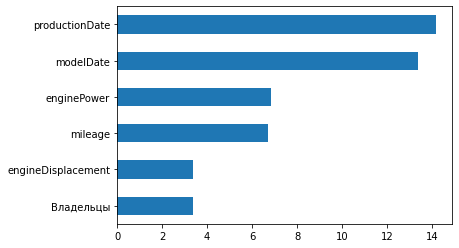

In [3035]:
imp_num = pd.Series(f_classif(data[num_cols][data['Train'] == 1], train['price'][data['Train'] == 1])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Признаки <b>'productionDate'</b> и <b>'modelDate'</b> оказались самым значимым из числовых.

#### Устранение выбросов

Посмотрим на выбросы:

<AxesSubplot:>

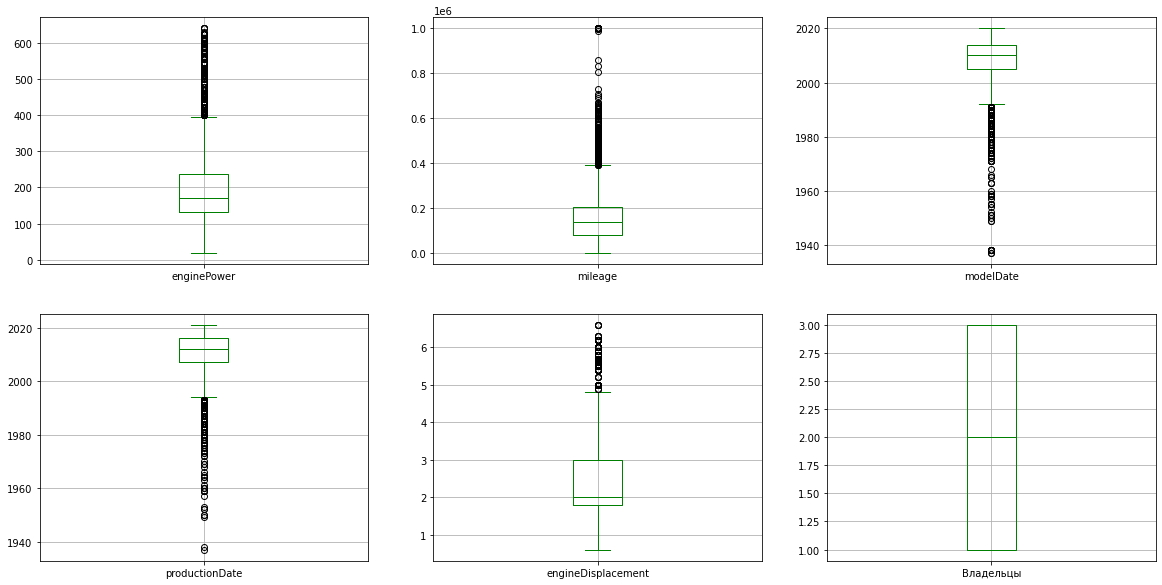

In [3036]:
fig = plt.figure(figsize=(20, 10))

ax_1 = fig.add_subplot(2, 3, 1)
ax_2 = fig.add_subplot(2, 3, 2)
ax_3 = fig.add_subplot(2, 3, 3)
ax_4 = fig.add_subplot(2, 3, 4)
ax_5 = fig.add_subplot(2, 3, 5)
ax_6 = fig.add_subplot(2, 3, 6) 

data[data['Train'] == 1].boxplot('enginePower', color='green', ax=ax_1)
data[data['Train'] == 1].boxplot('mileage', color='green', ax=ax_2)
data[data['Train'] == 1].boxplot('modelDate', color='green', ax=ax_3)
data[data['Train'] == 1].boxplot('productionDate', color='green',ax=ax_4)
data[data['Train'] == 1].boxplot('engineDisplacement', color='green', ax=ax_5)
data[data['Train'] == 1].boxplot('Владельцы', color='green', ax=ax_6)

Как можно заметить, в пяти из шести графиках присутствуют выбросы.

Напишем функцию для устранения выбросов:

In [3037]:
def del_blowout(feature):
    q3 = feature.quantile(q = 0.75)
    q1 = feature.quantile(q = 0.25)
    IQR = q3 - q1
    a = q1 - 1.5*IQR
    b = q3 + 1.5*IQR
    return feature.apply(lambda x: x if ((x > a) & (x < b)) else np.nan)

In [3038]:
# data['enginePower'][data['Train'] == 1] = del_blowout(data['enginePower'][data['Train'] == 1])
# data['mileage'][data['Train'] == 1] = del_blowout(data['mileage'][data['Train'] == 1])
# data['modelDate'][data['Train'] == 1] = del_blowout(data['modelDate'][data['Train'] == 1])
# data['productionDate'][data['Train'] == 1] = del_blowout(data['productionDate'][data['Train'] == 1])
# data['engineDisplacement'][data['Train'] == 1] = del_blowout(data['engineDisplacement'][data['Train'] == 1])
# data.dropna(subset=['enginePower', 'mileage', 'modelDate', 'productionDate', 'engineDisplacement'], inplace=True)

Как показали тесты, метрика на валидационной выборке значительно улучшилось после удаления выбросов. Однако, метрика на тестовой конкурсной выборке заметно упало. Скорее всего, это из-за того, что атипичные результаты присутствуют и в тестовой выборке. Поэтому, все выбросы оставил как есть.

### Категориальные переменные

#### LabelEncoder

Для начала, сделаем LabelEncoder для всех нечисловых признаков, чтобы оценить их значимость.

In [3039]:
lbl_encode = LabelEncoder()

In [3040]:
union_cat = copy(cat_cols)
union_cat.extend(['vendor', 'ПТС', 'Руль'])

In [3041]:
for i in union_cat:
    data[i] = lbl_encode.fit_transform(data[i])

#### Значимость категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию <b>mutual_info_classif</b> из библиотеки sklearn.

<AxesSubplot:>

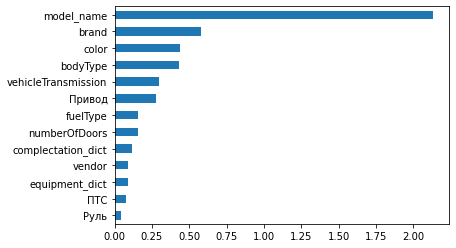

In [3042]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols][data['Train'] == 1], data['price'][data['Train'] == 1],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Признак <b>'model name'</b> оказался самым важным из категориальных.

#### OneHotEncoder

Теперь для некоторых признаков сделаем OneHotEncoder.

In [3043]:
cols_for_ohe = ['fuelType', 'vehicleTransmission', 'Привод', 'numberOfDoors']

Чтобы не раздувать признаковое пространство, переведем в OneHotEncoder только несколько немногочисленных признаков.

In [3044]:
data = pd.get_dummies(data, columns = cols_for_ohe)

In [3045]:
cat_cols = ['bodyType', 'brand', 'color', 'model_name'] # признаки, которые остались в категориальных

### Feature Engineering:

На основе имеющихся признаков создадим новые, которые улучшат метрику.

Создадим два новых признака на основе года выпуска модели. <br>
<b>'model_old'</b> - признак для машин до 2000 года. <br>
<b>'model_new'</b> - признак для машин после 2018 года.

In [3046]:
print(data['productionDate'].quantile(q = 0.1))
print(data['productionDate'].quantile(q = 0.9))

2000.0
2018.0


In [3047]:
data['model_old'] = data['productionDate'].apply(lambda x: 1 if x <= 2000 else 0)
data['model_new'] = data['productionDate'].apply(lambda x: 1 if x >= 2018 else 0)

Посмотрим на марки, которые в среднем самые дорогие:

In [3048]:
data[data['Train']==1].groupby(by='brand').mean().sort_values(by='price', ascending=False)['price']

brand
5     3.031895e+06
4     2.558205e+06
1     2.230455e+06
3     1.679413e+06
9     1.585501e+06
0     1.367192e+06
11    1.176284e+06
10    9.738221e+05
8     7.860916e+05
7     7.833758e+05
2     7.409856e+05
6     7.377014e+05
Name: price, dtype: float64

Создадим два новых признака на основе марки авто. <br>
<b>'model_premium'</b> - признак для самых дорогих марок. <br>
<b>'model_budget'</b> - признак для самых дешевых марок.

In [3049]:
data['model_premium'] = data['brand'].apply(lambda x: 1 if x in [5, 4, 1] else 0)
data['model_budget'] = data['brand'].apply(lambda x: 1 if x in [2, 6, 7, 8] else 0)

Попробуем создать еще несколько признаков на основе имеющихся:

In [3050]:
#data['new_feat1'] = data['enginePower']*data['engineDisplacement']
#data['new_feat2'] = data['enginePower']*data['productionDate']
#data['new_feat3'] = data['enginePower']/data['mileage']
#data['new_feat4'] = data['engineDisplacement']*data['productionDate']
data['new_feat5'] = data['engineDisplacement']/data['mileage']
data['new_feat6'] = data['productionDate']/data['mileage']

Оставим признаки <b>'new_feat5'</b> и <b>'new_feat6'</b>. Они лучше всего показали себя при тестах.

## Обучение модели

Разделим нашу общую выборку на обучающую и тестовую, удалив признаки <b>'sell_id'</b>. 

In [3051]:
X = data[data['Train'] == 1].drop(['sell_id','price'] , axis = 1)
X_test = data[data['Train'] == 0].drop(['sell_id','price'], axis = 1)
Y = np.log(data['price'].dropna()) # берем целевую переменную в логарифм для уменьшения разброса

In [3052]:
# разобъем выборку на обучающую и валидационную:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

Создадим метрику, по которой будет оптимизироваться SearchCV:

In [3053]:
mape_score = make_scorer(score_func=mape, greater_is_better = False)

### RandomForestRegressor

Обучим для начала нашу модель с параметрами по умолчанию:

In [3054]:
start_model = datetime.now()

rf = RandomForestRegressor(random_state = RANDOM_SEED)
rf.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)

Время выполнения: 0:00:17.086715


In [3055]:
predict_test = np.exp(rf.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Точность модели по метрике MAPE: 14.20%


Получили точность в <b>14.2%</b>. <br>
Попробуем ее улучшить, задав сетку гиперпараметров, которые будут перебираться:

In [3056]:
n_estimators = [100, 250, 500, 1000] # кол-во деревьев в лесу
max_features = ['auto', 'sqrt'] # кол-во признаков, которые следует учитывать при поиске лучшего сплита 
max_depth = [10, 25, 50, 100] # максимальная глубина дерева 
min_samples_split = [2, 5, 10] # минимальное количество выборок, необходимых для разделения внутреннего узла 
min_samples_leaf = [1, 2, 4] # минимальное количество выборок, которое должно быть в листе.
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [3057]:
start_model = datetime.now()

# параметров много, поэтому выбрал RandomForestRegressor
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, scoring=mape_score,
                               cv=3, verbose=2, random_state=RANDOM_SEED, n_jobs=-1)
rf_random.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)
print('Лучшие параметры:', rf_random.best_params_)

Мы получили следующие лучшие гиперпараметры для нашей модели:<br>
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}. <br>
Теперь заново обучим нашу модель, но уже с новыми гиперпараметрами.

In [3058]:
start_model = datetime.now()

rf = RandomForestRegressor(random_state = RANDOM_SEED,
                           n_estimators = 1000,
                           min_samples_split = 2,
                           min_samples_leaf = 1,
                           max_features = 'sqrt',
                           max_depth = 50)
rf.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)

predict_test = np.exp(rf.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Время выполнения: 0:00:42.076809
Точность модели по метрике MAPE: 13.93%


Таким образом, с помощью подбора гиперпараметров мы улучшили нашу метрику до <b>13.93%</b>.

### CatBoostRegressor

Обучим нашу модель с параметрами по умолчанию, указав <b>'cat_features'</b> и <b>'eval_metric'</b>:

In [3059]:
start_model = datetime.now()

cb = CatBoostRegressor(random_state = RANDOM_SEED,
                       cat_features=cat_cols,
                       eval_metric='MAPE',
                       silent=True)
cb.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)

Время выполнения: 0:00:13.704416


In [3060]:
predict_test = np.exp(cb.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Точность модели по метрике MAPE: 13.56%


Получили результат <b>13,56%</b>. <br>
Попробуем его улучшить, подобрав гиперпараметры. <br>
Зададим сетку гиперпараметров и попробуем подобрать оптимальные из них.

In [3061]:
param_grid = {
    'n_estimators': [500,1000],
    'max_depth': [3,5,7],
    'eta': [None, 0.01, 0.1, 1.],
}

In [3062]:
start_model = datetime.now()

cb = CatBoostRegressor(random_state = RANDOM_SEED,
                       cat_features=cat_cols,
                       eval_metric='MAPE',
                       silent=True)

# параметров не так много, поэтому выбрали GridSearchCV
cb_grid = GridSearchCV(estimator=cb, param_grid=param_grid, scoring=mape_score, cv=3, n_jobs=-1)
cb_grid.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)
print('Лучшие параметры:', cb_grid.best_params_)

Мы получили следующие лучшие гиперпараметры для нашей модели: <br>
{'eta': 0.1, 'max_depth': 7, 'n_estimators': 1000}.<br>
Теперь заново обучим нашу модель, но уже с новыми гиперпараметрами.<br>

In [3063]:
start_model = datetime.now()

cb = CatBoostRegressor(random_state = RANDOM_SEED,
                       cat_features=cat_cols,
                       eval_metric='MAPE',
                       silent=True,
                       eta=0.1,
                       max_depth=7,
                       n_estimators=1000
                      )
cb.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)
predict_test = np.exp(cb.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Время выполнения: 0:00:17.772455
Точность модели по метрике MAPE: 13.10%


Получился результат <b>13,10%</b>. <br>

### XGBRegressor

Обучим нашу модель с параметрами по умолчанию.

In [3064]:
start_model = datetime.now()

xgb = XGBRegressor(random_state = RANDOM_SEED, verbosity=0)
xgb.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)

Время выполнения: 0:00:02.572089


In [3065]:
predict_test = np.exp(xgb.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Точность модели по метрике MAPE: 14.06%


Получили результат <b>14,06%</b>. <br>
Попробуем его улучшить, подобрав гиперпараметры. <br>
Зададим сетку гиперпараметров и попробуем подобрать оптимальные из них.

In [3066]:
param_grid = {
    'n_estimators': [500,1000],
    'max_depth': [3,5,7],
    'learning_rate': [0.01, 0.1, 1.],
}

In [3067]:
start_model = datetime.now()

xgb = XGBRegressor(random_state = RANDOM_SEED, verbosity=0)

# параметров не так много, поэтому выбрали GridSearchCV
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring=mape_score, cv=3, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)
print('Лучшие параметры:', xgb_grid.best_params_)

Мы получили следующие оптимальные гиперпараметры для нашей модели: <br>
{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}. <br>
Теперь заново обучим нашу модель, но уже с новыми гиперпараметрами.

In [3068]:
start_model = datetime.now()

xgb = XGBRegressor(random_state = RANDOM_SEED, verbosity=0, learning_rate = 0.1, n_estimators=500, max_depth=7)
xgb.fit(X_train, y_train)

stop_model = datetime.now()

print('Время выполнения:', stop_model-start_model)

Время выполнения: 0:00:15.336258


In [3069]:
predict_test = np.exp(xgb.predict(X_val))
print(f"Точность модели по метрике MAPE: {(mape(np.exp(y_val), predict_test)):0.2f}%")

Точность модели по метрике MAPE: 13.17%


После подбора гиперпараметров точность метрики увеличилась до <b>13.17%</b>. 

Таким образом, немного лучше результат показала модель <b>CatBoostRegressor</b>, поэтому и результат с нее был отправлен на <b>submission</b>.

### Поправка на инфляцию

Т.к. тестовые данные собирались больше года назад, то не лишним будет сделать поправку на инфляцию. <br>
Уровень инфляции в 2020: <b>4,91%</b> <br>
Уровень инфляции с начала 2021 года: <b>2,72%</b><br>
Реальный же уровень инфляции скорее всего был намного больше, поэтому оптимальной цифрой для submission стал показатель в <b>15%.</b>


In [3070]:
predict_submission = np.exp(cb.predict(X_test)) / 1.15

In [3071]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.527340e+05
1,1100549428,8.583363e+05
2,1100658222,8.862098e+05
3,1100937408,7.256583e+05
4,1101037972,7.941436e+05
5,1100912634,7.836568e+05
6,1101228730,7.798946e+05
7,1100165896,3.928665e+05
8,1100768262,1.690871e+06
9,1101218501,1.034805e+06


<b>Выводы:</b>
1) Для сбора тренировочных данных была написана программа, которая собрала данные с auto.ru.<br>
2) Добытые данные были обработаны. Пропуски заполнены. Данные были приведены к единому виду.<br>
3) Данные были визуализированы. Проанализированы на выбросы.<br>
4) Сгенерированы новые признаки.<br>
5) Был проведен анализ трех алгоритмов. К каждому алгоритму подобраны гиперпараметры.<br>
6) В результате лучший результат был отправлен на <b>'submission'</b> в конкурсе Kaggle.